# Create Distance Infographic - Cosmic Explorer Trade Study 

This Notebook reads from the output of Bayesian inference runs and creates a distance infographic for measuring the parameters of a CBC signal to within 10% accuracy.

### Import modules

In [1]:
import numpy
import matplotlib.pyplot as plt
import json
from matplotlib.patches import Patch
import seaborn as sns
from glob import glob

plt.style.use('dark_background')
%matplotlib inline


In [2]:
# sns.palplot(sns.light_palette("orange", 4))
# palette = sns.color_palette("Blues_r", 4)
palette = sns.color_palette("hls", 8)
# define a dictionary to standardize the colors for different parameters
color_dict = {'CE-40':palette[4], 'CE-20':palette[5], 
#               'CE-40 + CE-20':palette[2],
              'CE-40 + CE-20':palette[2], 'LVK':palette[0]}

label_dict = {"NS-radius": r"Time to constrain NS radius to within 100 m",
              "sky-loc": r"Time to Locate 100 sources to within 1 sq. deg.",
              "early-detection": r"Time to detect 10 sources 60 seconds before merger",
              "H0": r"Time to measure $H_0$ to within $1\%$",
              "Omega": r"Time to measure $\Omega$ to within $10\%$",
              "GR": r"Time to measure GR to a precision of $10^{-10}$",
              "BH-mass-spectrum": r"Time to measure BH mass spectrum",
              "NS-mass-spectrum": r"Time to measure NS mass spectrum",
             }

In [3]:
def plot_dist_bar(network_dict, nw_number):
    '''
    Evaluates the x-ranges for the broken bar for
    each parameter from the dictionary values. Plots 
    the broken bars for each parameter.
    
    Parameters
    ----------
    network_dict: dictionary
        Dictionary with the disctance values
    
    nw_number: int
        Number id for the detctor network
    '''
    
    p = ax.barh(10*nw_number, network_dict['LVK'], left=0, height = 5, 
                color=color_dict['LVK'], alpha = 1, label=str(int(network_dict['LVK']))) 

    p = ax.barh(10*nw_number, network_dict['CE-20'], left=0, height = 5, 
                color=color_dict['CE-20'], alpha = 1, label=str(int(network_dict['CE-20'])))
    
    p = ax.barh(10*nw_number, network_dict['CE-40'], left=0, height = 5, 
                color=color_dict['CE-40'], alpha = 1., label=str(int(network_dict['CE-40'])))


    p = ax.barh(10*nw_number, network_dict['CE-40 + CE-20'], left=0, height = 5, 
                color=color_dict['CE-40 + CE-20'], alpha = 1, label=str(int(network_dict['CE-40 + CE-20']))) 
  

### Plotting the timelines

plotting times for NS-radius
plotting times for NS-mass-spectrum
plotting times for BH-mass-spectrum
plotting times for GR
plotting times for Omega
plotting times for H0
plotting times for early-detection
plotting times for sky-loc


/usr1/chaitanya.afle/ipykernel_1595184/1739090708.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-1, 150.)


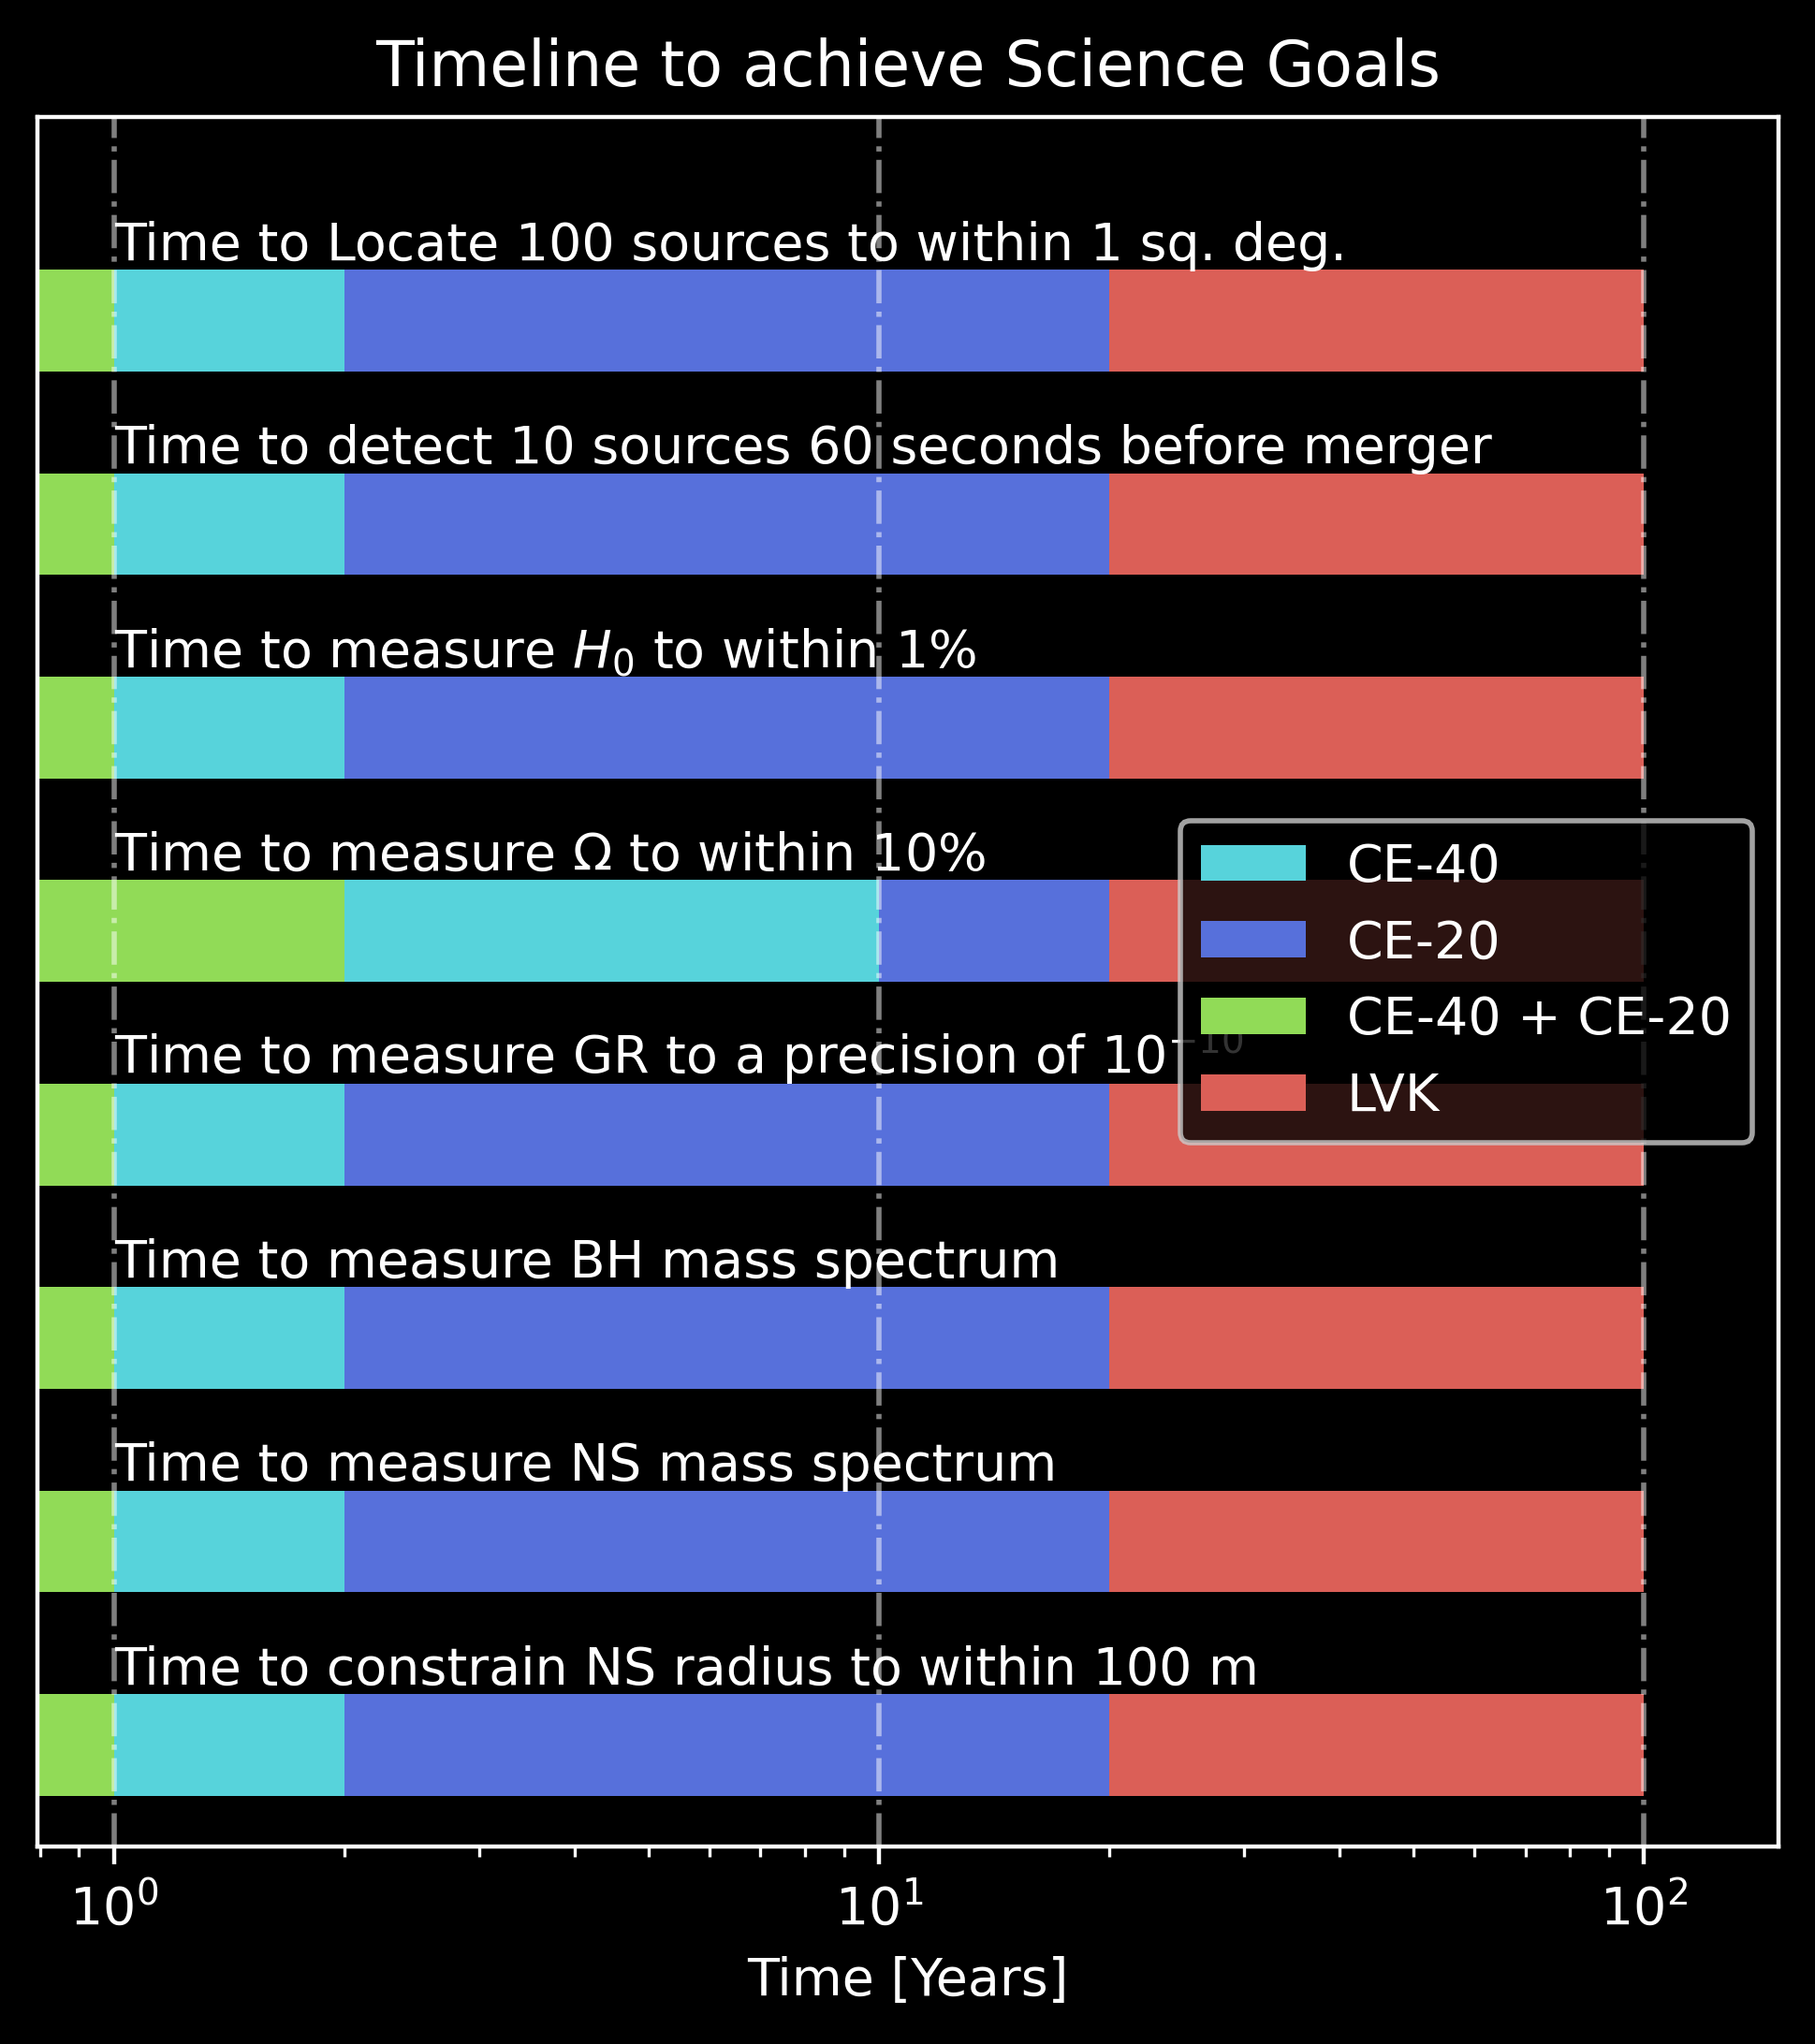

In [10]:
# list of all the network files
network_list = sorted(glob("timeline_plot_data/timeline_plot_data.txt"), reverse=True)

# example contents of a file:
# {"Name": "Time to constrain NS radius to within 10", "CE-40": 2, "CE-20": 20, "CE-40 + CE-20": 1, "LVK": 100}

# initiate a list of names for the detector networks
name_list = []

fig, ax = plt.subplots(figsize=[6, 6], dpi=400)

with open(network_list[0], 'r') as handle:
    json_data = [json.loads(line) for line in handle]
    
for ii in range(len(json_data)):
#     print(json_data[-ii])
    nw_dict = json_data[-ii]
    name = nw_dict['Name']
    print('plotting times for {}'.format(name))
    name_list.append(name)
    plot_dist_bar(nw_dict, ii+1)
    plt.text(1, 3+(10*(ii+1)), label_dict[name])

ax.set_ylim(5, len(json_data)*10+10)

ax.set_xlabel('Time [Years]')
ax.set_yticks([])
# ax.set_yticks([(ii*10 +10) for ii in range(len(json_data))], 
#               labels=name_list)     # Modify y-axis tick labels
# ax.grid(True)                                       

# create legend
legend_elements = [Patch(facecolor=color_dict['CE-40'], 
                         label='CE-40'),
                   Patch(facecolor=color_dict['CE-20'], 
                         label='CE-20'),
                   Patch(facecolor=color_dict['CE-40 + CE-20'], 
                         label='CE-40 + CE-20'),
                   Patch(facecolor=color_dict['LVK'], 
                         label='LVK')]
ax.legend(handles=legend_elements, loc='center right')
plt.xscale('log')
ax.set_xlim(-1, 150.)
plt.grid(which='major', axis='x', linestyle='-.', linewidth=1, alpha=0.5)
plt.title('Timeline to achieve Science Goals')
plt.savefig('time-infographic.png')
plt.show()